In [1]:
obj_dims = (648, 486)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import backend as K
from tensorflow.keras import layers


import os
import json
import scipy.io as sio
from os import path

from src.model import UNet_2d

import PIL
from PIL import Image

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [4]:
model_description = 'model-8.3'

In [5]:
real_data_path = path.join('..', 'data', 'real-data', 'realData.mat')
ground_truth_path = path.join('..', 'data', 'real-data', 'beads_GT.png')

# Paths for saving/loading model weights, predictions
base_path = path.join('..', 'models', model_description)
model_weights_path = path.join(base_path, model_description)
image_path = path.join(base_path, 'prediction-images')

# Testing

In [6]:
model = UNet_2d()
epoch = 'best'
model.load_weights(model_weights_path + '.{}'.format(epoch))

In [7]:
# Read in older mat files with scipy.io
data = sio.loadmat(real_data_path)

In [8]:
beads, res = data['beads'], data['resTarget']
beads = np.array(Image.fromarray(beads).resize(obj_dims, resample=PIL.Image.NEAREST))
b_min = np.min(beads)
b_max = np.max(beads)
beads_input_normed = ((beads - b_min) / (b_max - b_min)).T
beads_input = beads_input_normed.astype(np.float16)[np.newaxis, ..., np.newaxis]

In [9]:
res = np.array(Image.fromarray(res).resize(obj_dims, resample=PIL.Image.NEAREST))
r_min = np.min(res)
r_max = np.max(res)
res_input_normed = ((res - r_min) / (r_max - r_min)).T
res_input = res_input_normed.astype(np.float16)[np.newaxis, ..., np.newaxis]

In [10]:
pred_beads = model.predict(beads_input).squeeze()

In [11]:
pred_res = model.predict(res_input).squeeze()

In [12]:
beads_gt_im = Image.open(ground_truth_path)
beads_gt = np.array(beads_gt_im).T
# Normalize beads from 0 to 1
beads_gt = (beads_gt - np.min(beads_gt)) / (np.max(beads_gt) - np.min(beads_gt))

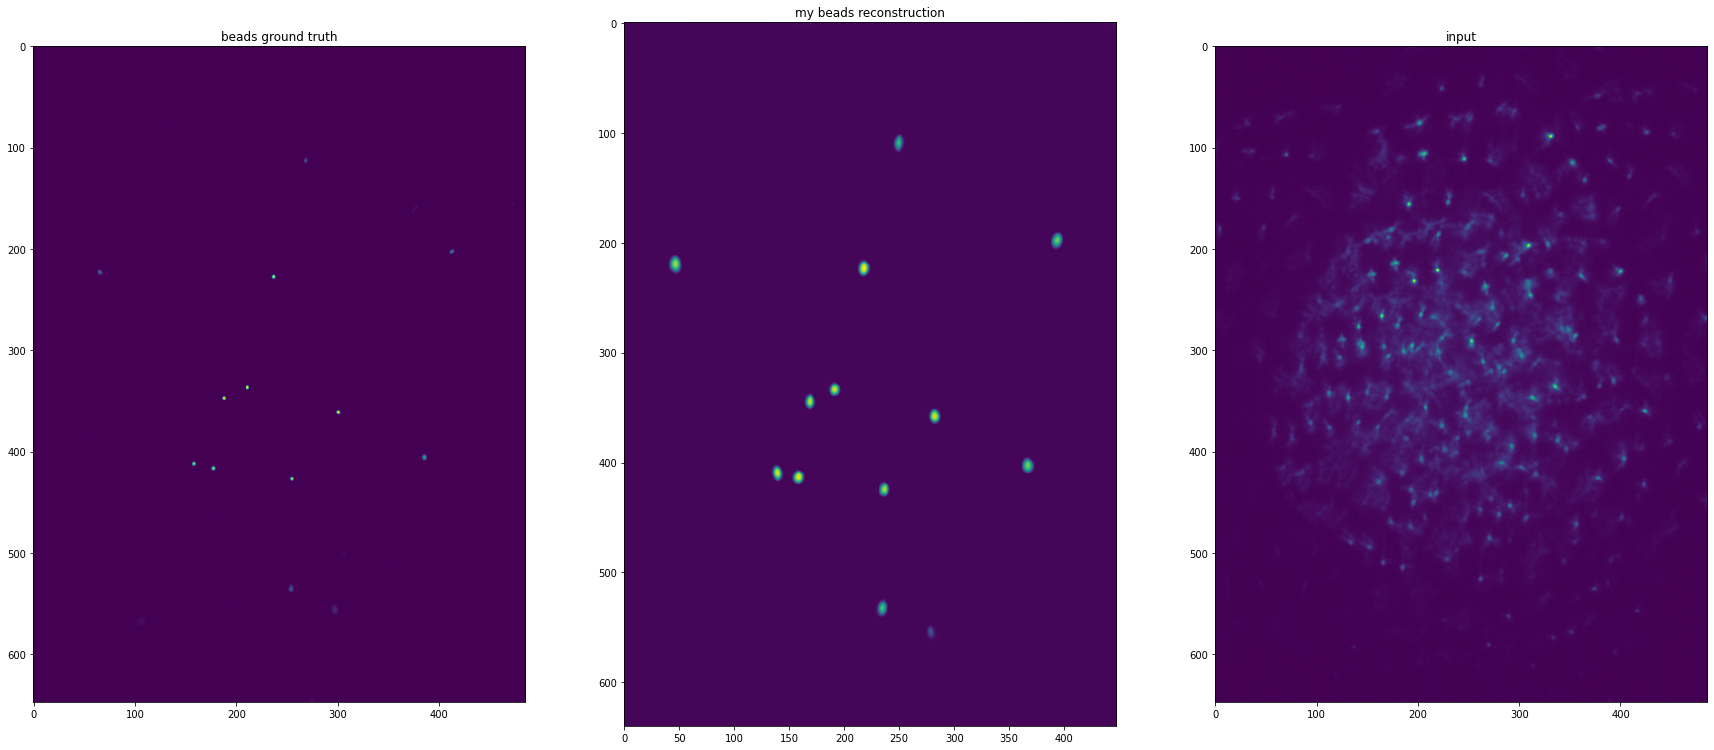

In [13]:
fig = plt.figure(figsize=(30, 30))
f0 = fig.add_subplot(1, 3, 1)
f0.set_title('beads ground truth')
f0.imshow(beads_gt)

f1 = fig.add_subplot(1, 3, 2)
f1.set_title('my beads reconstruction') # Normalized before simulation, but not after
f1.imshow(pred_beads)

f2 = fig.add_subplot(1, 3, 3)
f2.set_title('input')
f2.imshow(beads_input_normed)


plt.savefig(path.join(image_path, '{}_beads_reconstruction_{}.pdf'.format(model_description, epoch)))
plt.show()


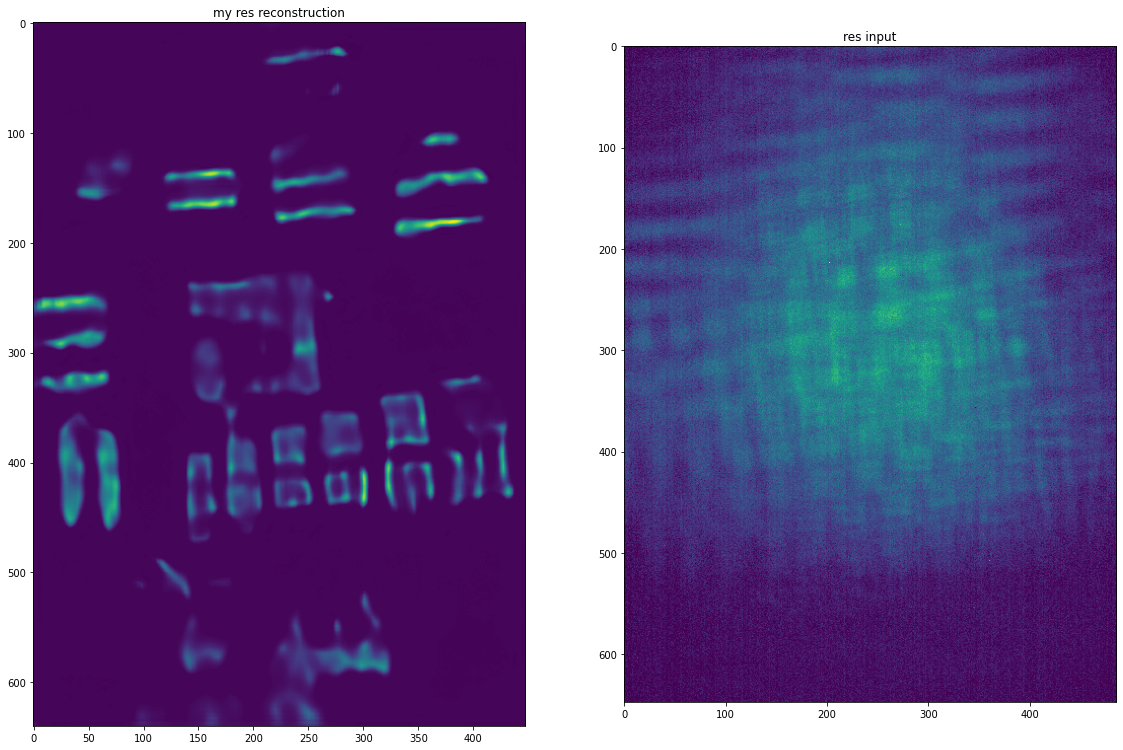

In [14]:
fig = plt.figure(figsize=(30, 30))
f1 = fig.add_subplot(1, 3, 2)
f1.set_title('my res reconstruction') # Normalized before simulation, but not after
f1.imshow(pred_res)

f2 = fig.add_subplot(1, 3, 3)
f2.set_title('res input')
f2.imshow(res_input_normed)

plt.savefig(path.join(image_path, '{}_res_reconstruction_{}.pdf'.format(model_description, epoch)))

plt.show()

In [45]:
print(np.max(pred_beads), np.min(pred_beads))

1.2329023 -2.1589859


In [26]:
print(np.max(beads_gt), np.min(beads_gt))

1.0 0.0


In [ ]:
print(np.max(pred_res), np.min(pred_res))

In [ ]:
print(np.max(res_input_normed), np.min(res_input_normed))